
---



> # *Categorical Face Mask detection with Convolutional NNs (CNN) using PyTorch*

```
>> Hello CNN
```


---

###**1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from PIL import Image
from datetime import datetime
from pytz import timezone

from google.colab import files
from google.colab import drive

import seaborn as sns
import torch
import torch.optim as optim

from torch.nn import Conv2d, BatchNorm2d, ReLU, Dropout2d, MaxPool2d, Sequential, Module, CrossEntropyLoss
from tqdm.notebook import tqdm
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



*   Mounting Google Drive and seed initialization



In [7]:
drive.mount('/content/drive', True)

# train directory
directory = 'drive/MyDrive/train'

# test directory
tst_dir = 'drive/MyDrive/test'


gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
torch.manual_seed(0)
% matplotlib inline
sns.set_style('darkgrid')
workers = 10 # for torch gpu

Mounted at /content/drive




---


###**2. Image Preprocessing**

#### 1- Resizing and Changing images format into jpg

In [8]:
counter = 0

for image in glob.glob('Source path/*.*'):
    img = Image.open(image)
    rgb_img = img.convert('RGB')
    new_image = rgb_img.resize((300, 300))
    new_image.save('Destination Path/' + str(counter) + '.jpg')
    counter += 1

print('All done!')

All done!


#### 2- Image transformation and Label definition

In [9]:
image_transforms = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
dataset = ImageFolder(
    root=directory,
    transform=image_transforms
)
idx2class = {
    v: k for k, v in dataset.class_to_idx.items()
    }

print('Dataset has', len(dataset), 'elements with the following classes:\n', dataset.class_to_idx)

Dataset has 1956 elements with the following classes:
 {'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [11]:
count_dict = {
    k: 0 for k, v in dataset.class_to_idx.items()
    }
    
for element in dataset:
    y_lbl = element[1]
    y_lbl = idx2class[y_lbl]
    count_dict[y_lbl] += 1

print("Distribution of classes: \n", count_dict)

Distribution of classes: 
 {'cloth': 396, 'n95': 354, 'n95v': 390, 'nfm': 474, 'srg': 342}


In [12]:
y_label_plt = []
count_of_y_label = []
for key, values in count_dict.items():
  y_label_plt.append(key)
  count_of_y_label.append(values)

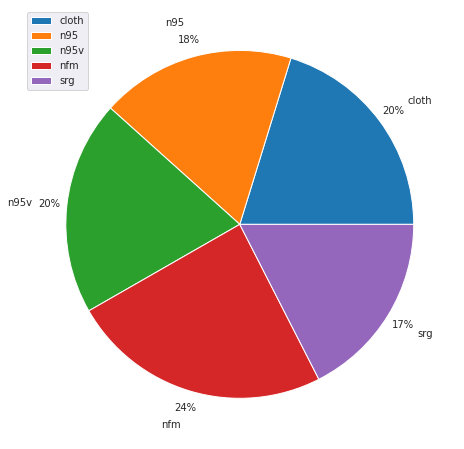

In [13]:
plt.pie(count_of_y_label, labels=y_label_plt, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.gcf().set_size_inches(8, 8)
plt.legend()
plt.show()

#### 3- Train Test Split

In [14]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [15]:
batch_size = 16
train_loader = DataLoader(dataset=dataset, batch_size=batch_size
                          , sampler=train_sampler, num_workers=workers)

val_loader = DataLoader(dataset=dataset, batch_size=1
                        , sampler=val_sampler, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k: 0 for k, v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _, label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _, label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Text(0.5, 1.0, 'Validation Set')

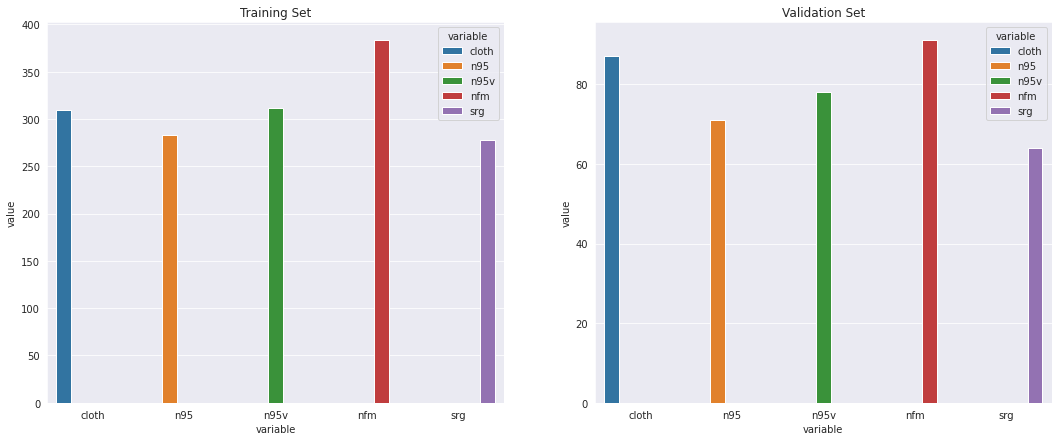

In [17]:
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data=pd.DataFrame.from_dict([dict_obj]).melt()
    , x="variable", y="value", hue="variable", **kwargs).set_title(plot_title)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

plot_from_dict(get_class_distribution_loaders(train_loader, dataset), plot_title="Training Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, dataset), plot_title="Validation Set", ax=axes[1])

In [18]:
single_batch = next(iter(train_loader))
single_image = single_batch[0][0]
print('Single batch: ', single_batch[0].shape)
print('single image shape: ', single_image.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Single batch:  torch.Size([16, 3, 300, 300])
single image shape:  torch.Size([3, 300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output label tensors:  tensor([0, 1, 3, 3, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 3])

Output label tensor shape:  torch.Size([16])


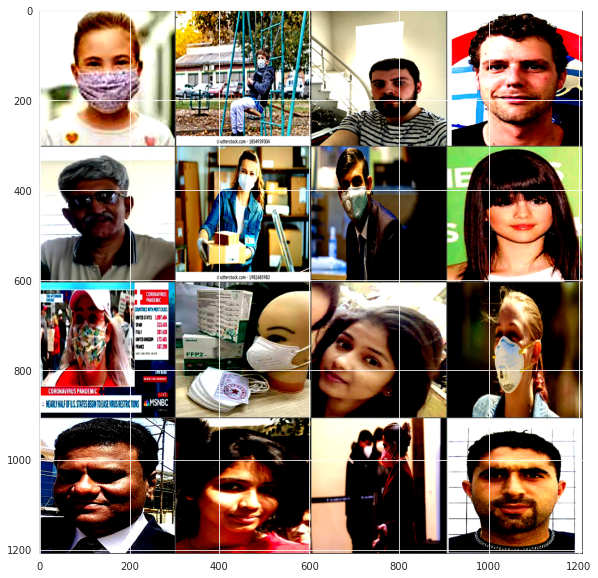

In [19]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(single_batch_grid.permute(1, 2, 0) + 0.3)
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)



---


### **3- Convolutional Neural Networks (CNN)**

We build Convolutional Neural Networks with three blocks.


*   First Conv2D is implemented
*   Then Batch Normal with Rectifier function
*   Dropout is considered 0.1

*In order to create the fully connected part, Maxpooling with filter size 2 is implemented, after applying Two Dimentional Conversation*

In order to find the output of the fully connected part, we apply the following equation.

\begin{align}
        output = \frac{InputSize - KernelSize + 2.padding}{stride factor} + 1
    \end{align}


---



    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

***padding is 0 by default***



#### 1- Model Hyper-Parameters

In [44]:
learning_rate = 0.00146
epochs = 20
wd = 1e-6
dropout = 0.1

#### 2- Building the Model

In [45]:
class CNN_Classifier(Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.block1 = self.conv_block(input=3, output=512, dropout=dropout, kernel_size=5, stride_factor=2)
        self.block2 = self.conv_block(input=512, output=256, dropout=dropout, kernel_size=3, stride_factor=2)
        self.block3 = self.conv_block(input=256, output=128, dropout=dropout, kernel_size=3, stride_factor=2)
        self.block4 = self.conv_block(input=128, output=64, dropout=dropout, kernel_size=3, stride_factor=2)

        # Fully Connected Network
        self.lastcnn = Conv2d(in_channels=64, out_channels=5, kernel_size=4, stride=2)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x

    def conv_block(self, input, output, dropout, kernel_size, stride_factor):
        cnn_model_block = Sequential(
            Conv2d(in_channels=input, out_channels=output, kernel_size=kernel_size, stride=stride_factor),
            BatchNorm2d(num_features=output),
            ReLU(),
            Dropout2d(p=dropout)
        )
        return cnn_model_block

In [46]:
# Model Summary
print(CNN_Classifier())

CNN_Classifier(
  (block1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 5, kernel_size=(4, 4

#### 3- Training the Model

In [47]:
def measure_acc(y_predict, y_test):
    y_pred_softmax = torch.log_softmax(y_predict, dim=1)
    _, y_pred = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred == y_test).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    accuracy = torch.round(accuracy * 100)
    return accuracy

In [48]:
accuracy_stats = {
    'train': [],
    "validation": []
}

loss_stats = {
    'train': [],
    "validation": []
}

pre_trained_model = False

print("Training begins at:", datetime.now(timezone('EST')).strftime("%H:%M"))
cnn_model = CNN_Classifier()

try:
  cnn_model.load_state_dict(torch.load('drive/MyDrive/model_weights.pth'))
  cnn_model.eval()
  pre_trained_model = True
  print('Using pretrained model..')

except:
  print('Training model training')
  cnn_model.to(gpu)
  loss = CrossEntropyLoss()
  optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=wd)

  
  for epoch in tqdm(range(1, epochs + 1)):

      # TRAINING
      train_epoch_loss = 0
      train_epoch_acc = 0
      cnn_model.train()

      for X_train, y_train in train_loader:
          X_train, y_train = X_train.to(gpu), y_train.to(gpu)

          optimizer.zero_grad()
          y_train_pred = cnn_model(X_train).squeeze()

          train_loss = loss(y_train_pred, y_train)
          train_acc = measure_acc(y_train_pred, y_train)

          train_loss.backward()
          optimizer.step()

          train_epoch_loss += train_loss.item()
          train_epoch_acc += train_acc.item()

      # VALIDATION
      with torch.no_grad():

          val_epoch_loss = 0
          val_epoch_acc = 0
          cnn_model.eval()

          for X_val, y_val in val_loader:
              X_val, y_val = X_val.to(gpu), y_val.to(gpu)
              y_val_pred = cnn_model(X_val).squeeze()
              y_val_pred = torch.unsqueeze(y_val_pred, 0)

              val_loss = loss(y_val_pred, y_val)
              val_acc = measure_acc(y_val_pred, y_val)
              val_epoch_loss += train_loss.item()
              val_epoch_acc += train_acc.item()

      loss_stats['train'].append(train_epoch_loss / len(train_loader))
      loss_stats['validation'].append(val_epoch_loss / len(val_loader))
      accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
      accuracy_stats['validation'].append(val_epoch_acc / len(val_loader))
      
      print(
          f'Epoch {epoch + 0:02}: | Train Loss: {train_epoch_loss / len(train_loader):.5f} '
          f'| Validation Loss: {val_epoch_loss / len(val_loader):.5f} '
          f'| Train Accuracy: {train_epoch_acc / len(train_loader):.3f}'
          f'| Validation Accuracy: {val_epoch_acc / len(val_loader):.3f}')
    
print("Training ends at:", datetime.now(timezone('EST')).strftime("%H:%M"))

Training begins at: 12:34
Using pretrained model..
Training ends at: 12:34



#### 4- Ploting the accuracy and loss





In [49]:

if pre_trained_model == False:
  epochstoplot = range(1, epochs + 1)
  plt.plot(epochstoplot, loss_stats['train'], 'g', label='Training loss')
  plt.plot(epochstoplot, loss_stats['validation'], 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print(cnn_model.state_dict())


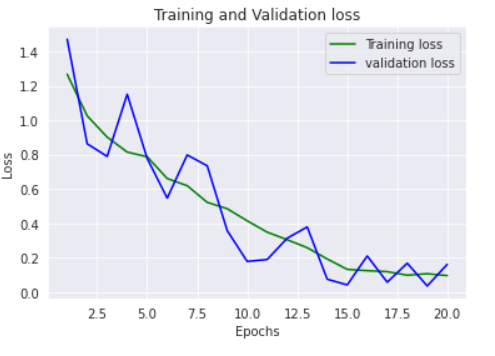

In [50]:

if pre_trained_model == False:

  epochstoplot = range(1, epochs + 1)
  plt.plot(epochstoplot, accuracy_stats['train'], 'g', label='Training loss')
  plt.plot(epochstoplot, accuracy_stats['validation'], 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

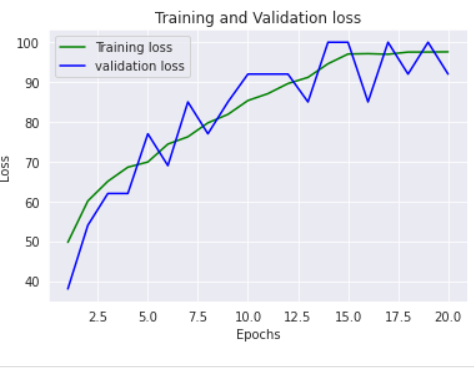



---


### **4. Testing the CNN model**

#### 1- Image transformation and y_true definition


In [52]:
image_transforms_tst = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Uncomment for demo on single image
# if True:     
#   tst_dir = 'drive/MyDrive/demo'

test_set = datasets.ImageFolder(root=tst_dir,
                                    transform=image_transforms_tst)

#### 2- Testing

In [54]:
# {'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

test_loader = DataLoader(dataset=test_set, shuffle=True, batch_size=1, num_workers=workers)

y_pred_list = []
y_true_list = []

TGREEN = '\033[1;37;42m'
TRED = '\033[1;37;41m'
TBLUE = '\033[1;34;40m'

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x, y = x.to(gpu), y.to(gpu)

        img_x = utils.make_grid(x)

        

        y_test_pred = cnn_model(x)
        _, y_pred = torch.max(y_test_pred, dim=1)

        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y.cpu().numpy())

        # Change boolean to show labels with image
        if pre_trained_model == False:
          plt.imshow(img_x.permute(1, 2, 0) + 0.3)
          plt.show()
          if y_pred == 0:
              print(TGREEN + "The person is wearing a cloth mask. \n")
          elif y_pred == 1:
              print(TRED + "The person is wearing a n95 mask.\n")
          elif y_pred == 2:
              print(TRED + "The person is wearing a n95 mask with valve.\n")
          elif y_pred == 3:
              print(TRED + "The person is not wearing a mask.\n")
          elif y_pred == 4:
              print(TRED + "The person is wearing a surgical mask.\n")
          else:
              print(TBLUE + "The person is wearing a surgical mask.\n")
          print('\n')

y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/330 [00:00<?, ?it/s]

#### 3- Comparing test results

In [55]:
print('______________________ /CLASSIFICATION REPORTS\ _______________________\n')
print(classification_report(y_true_list, y_pred_list))
print('\n_________________________ /CONFUSION MATRIX\ __________________________\n')
print(confusion_matrix(y_true_list, y_pred_list))
print('\n_________________________ /ACCURACY SCORE\ __________________________\n')
print(f'% {accuracy_score(y_true_list, y_pred_list):.3f}')

______________________ /CLASSIFICATION REPORTS\ _______________________

              precision    recall  f1-score   support

           0       0.77      0.69      0.73        78
           1       0.67      0.78      0.72        50
           2       0.69      0.67      0.68        49
           3       0.81      0.85      0.83        78
           4       0.77      0.75      0.76        75

    accuracy                           0.75       330
   macro avg       0.74      0.75      0.74       330
weighted avg       0.75      0.75      0.75       330


_________________________ /CONFUSION MATRIX\ __________________________

[[54  4  4 10  6]
 [ 4 39  3  2  2]
 [ 3  3 33  3  7]
 [ 3  3  4 66  2]
 [ 6  9  4  0 56]]

_________________________ /ACCURACY SCORE\ __________________________

% 0.752


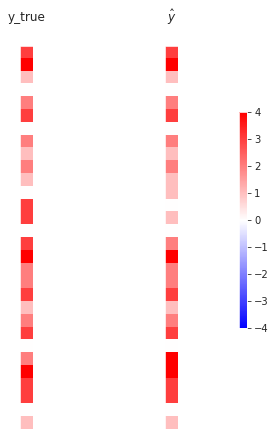

In [56]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list[: 30]),
    '$\hat{y}$': torch.FloatTensor(y_pred_list[: 30])
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))